## Final Project - Phase 1

### Neural Style Transfer Libraries

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from torchvision.utils import save_image
import torch
import torchvision

### Poisson Blending libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr

In [3]:
#check if there is gpu available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no gpu

In [4]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
# import pretrain model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [12]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## Final Project - Phase 2

#### Poisson Blending functions

In [15]:
def poisson_blend(content, cnn_output, alpha=0.5):
    """
    :param content: numpy.ndarray Input image
    :param cnn_output: numpy.ndarray Generated output from the Convolutional Neural Network
    """
    
    H, W, C = content.shape
    V = np.zeros((H, W, C))

    print("Input image shape: {}\n".format(content.shape))

    for c in range(C):
        source = content[:,:,c]
        target = cnn_output[:,:,c]

        rows = []
        cols = []
        coefficients = []
        b = []
        row = 0

        print("Channel {}:".format(c+1))
        print("\tBuilding matrix.")
        for y in range(H-1):
            for x in range(W-1):
                rows.append(row)
                cols.append(x + W*(y+1))
                coefficients.append(1)

                rows.append(row)
                cols.append(x + W*y)
                coefficients.append(-1)

                b.append((1-alpha)*(source[y+1][x] - source[y][x]) + alpha*(target[y+1][x] - target[y][x]))
                row += 1

                rows.append(row)
                cols.append((x+1) + W*y)
                coefficients.append(1)

                rows.append(row)
                cols.append(x + W*y)
                coefficients.append(-1)
                b.append((1-alpha)*(source[y][x+1] - source[y][x]) + alpha*(target[y][x+1] - target[y][x]))
                row += 1

        rows.append(row)
        cols.append(W + 1)
        coefficients.append(1)
        b.append((1-alpha)*source[1][1] + alpha*target[1][1])
        row += 1

        rows.append(row)
        cols.append(H*W - 1)
        coefficients.append(1)
        b.append((1-alpha)*source[-1][-1] + alpha*target[-1][-1])
        row += 1

        A = csr_matrix((coefficients, (rows, cols)), shape=(row, H*W))
        print("\t\tMatrix built: {}".format(A.shape))

        print("\tSolving for v.")
        v = lsqr(A, b)[0].reshape((H,W))
        v = np.clip(v, 0, 1)
        V[:, :, c] = v
        print("\tSolved.\n")

    return V

## Running the whole pipeline

In [16]:
def runn(content_path, style_path, output_path, poisson_alpha=0.5):
    content_img = image_loader(content_path)
    style_img = image_loader(style_path)

    assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"
    
    input_img = content_img.clone()
    # if you want to use white noise instead uncomment the below line:
    # input_img = torch.randn(content_img.data.size(), device=device)
    
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    
    save_image(output, 'preprocessed/cnn_output.jpg')
    
    cnn_output = cv2.cvtColor(cv2.imread('preprocessed/cnn_output.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
    content    = cv2.cvtColor(cv2.imread(content_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
    content    = cv2.resize(content, (imsize, imsize))
    style      = cv2.cvtColor(cv2.imread(style_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
    style      = cv2.resize(style, (imsize, imsize))

    im_blend = poisson_blend(content, cnn_output, alpha=poisson_alpha)
    cv2.imwrite(output_path, cv2.cvtColor((im_blend * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    
    fig, axes = plt.subplots(2,2)
    fig.set_figwidth(10)
    fig.set_figheight(10)

    axes[0][0].imshow(content)
    axes[0][0].set_title("Content")

    axes[0][1].imshow(style)
    axes[0][1].set_title("Style")

    axes[1][0].imshow(cnn_output)
    axes[1][0].set_title("CNN Output")

    axes[1][1].imshow(im_blend)
    axes[1][1].set_title("Poisson Blend");

Building the style transfer model..


/Users/gabriel/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/gabriel/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 254.372635 Content Loss: 20.272310

run [100]:
Style Loss : 71.606537 Content Loss: 19.775282

run [150]:
Style Loss : 23.893045 Content Loss: 17.606470

run [200]:
Style Loss : 15.056590 Content Loss: 14.665879

run [250]:
Style Loss : 10.944956 Content Loss: 13.037371

run [300]:
Style Loss : 7.717021 Content Loss: 12.126173

Input image shape: (256, 256, 3)

Channel 1:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.

Channel 2:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.

Channel 3:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.



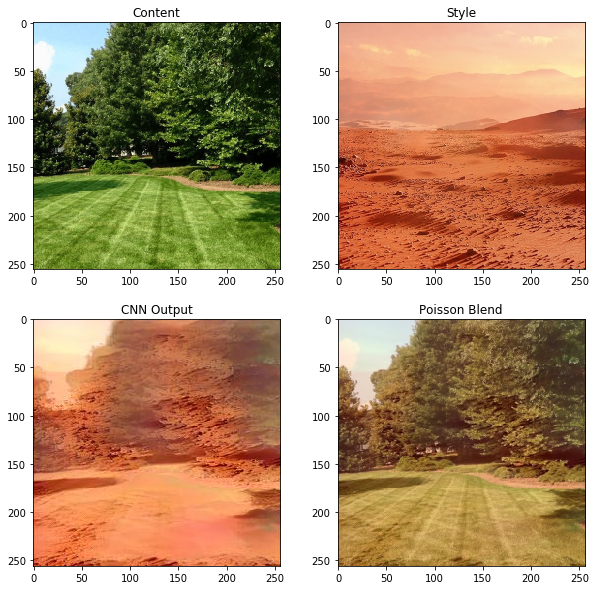

In [17]:
# Modify these
content_path    = 'samples/mars_in.jpg'
style_path      = 'samples/mars_style.jpg'
output_path     = 'output/mars_output.jpg'

runn(content_path, style_path, output_path, poisson_alpha=0.5)

Building the style transfer model..


/Users/gabriel/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/gabriel/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 315.977600 Content Loss: 37.825859

run [100]:
Style Loss : 84.951202 Content Loss: 39.187107

run [150]:
Style Loss : 44.456238 Content Loss: 39.495365

run [200]:
Style Loss : 29.310902 Content Loss: 39.225113

run [250]:
Style Loss : 20.495125 Content Loss: 38.752739

run [300]:
Style Loss : 14.259451 Content Loss: 38.287319

Input image shape: (256, 256, 3)

Channel 1:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.

Channel 2:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.

Channel 3:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.



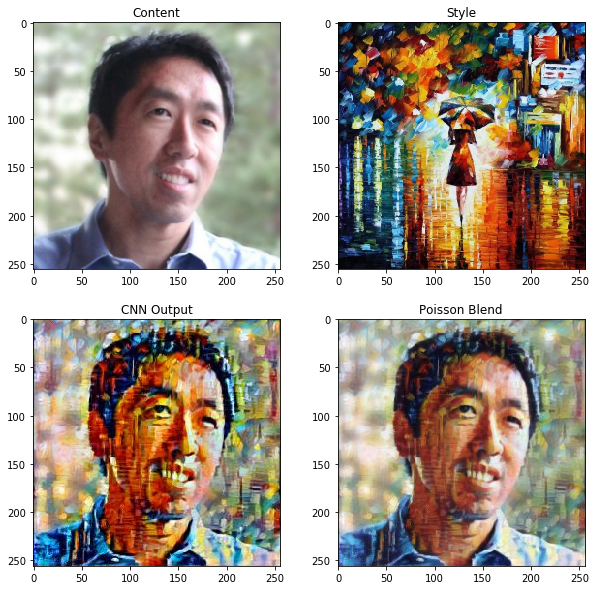

In [18]:
# Modify these
content_path    = 'samples/andrew_in.jpg'
style_path      = 'samples/andrew_style.jpg'
output_path     = 'output/andrew_output.jpg'

runn(content_path, style_path, output_path, poisson_alpha=0.5)

Building the style transfer model..


/Users/gabriel/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/gabriel/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 82.936646 Content Loss: 12.777767

run [100]:
Style Loss : 46.013355 Content Loss: 12.190023

run [150]:
Style Loss : 31.190161 Content Loss: 11.707497

run [200]:
Style Loss : 18.587685 Content Loss: 11.218902

run [250]:
Style Loss : 9.619375 Content Loss: 10.548643

run [300]:
Style Loss : 4.595505 Content Loss: 9.449301

Input image shape: (256, 256, 3)

Channel 1:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.

Channel 2:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.

Channel 3:
	Building matrix.
		Matrix built: (130052, 65536)
	Solving for v.
	Solved.



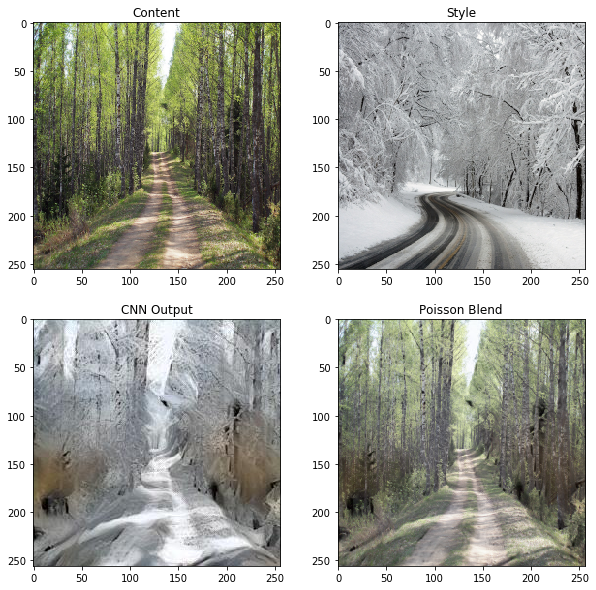

In [19]:
# Modify these
content_path    = 'samples/forest_in.jpg'
style_path      = 'samples/forest_style.jpg'
output_path     = 'output/forest_output.jpg'

runn(content_path, style_path, output_path, poisson_alpha=0.5)